# Интеллектуальный анализ данных – весна 2025
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.
* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [5]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [6]:
df = pd.read_csv('data/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
25234,34710,79662,United Kingdom,06-04-2020,Workers face the twin effects of rising prices...,Positive
29325,39787,84739,Philadelphia ? Fort Worth,09-04-2020,Professor Hannah Bloch Wehba was quoted in an ...,Negative
28678,38990,83942,Ferrum Stadium (She/Her),08-04-2020,the end half of 2020 is shaping up to be a gre...,Negative
11767,18071,63023,"Lincoln, United Kingdom",21-03-2020,Why is nobody panic buying vegan food? It's th...,Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная или очень положительная эмоциональная окраска и 0 - если отрицательная или очень отрицательная.

In [7]:
df['Sentiment'].value_counts()

Sentiment
Positive              11422
Negative               9917
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64

In [8]:
df['Sentiment'] = df['Sentiment'].apply(lambda x: 1 if x in ['Positive', 'Extremely Positive'] else 0)
df['Sentiment'].value_counts()

Sentiment
1    18046
0    15398
Name: count, dtype: int64

Сбалансированы ли классы?

In [9]:
positive = df['Sentiment'].value_counts()[1]
negative = df['Sentiment'].value_counts()[0]

print(f'Proportion of positive tweets: {positive / (positive + negative)}')
print(f'Proportion of negative tweets: {negative / (positive + negative)}')

Proportion of positive tweets: 0.5395885659610095
Proportion of negative tweets: 0.46041143403899054


**Ответ:** Сбалансированы

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [10]:
df.isna().sum()

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [11]:
df.fillna('Unknown', inplace=True)
df.isna().sum()

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и укажите `random_state=0`

In [12]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведения токенов в нижний регистр.

In [13]:
train_dict = train['OriginalTweet'].apply(lambda x: x.split()).explode().str.lower().value_counts().to_dict()
train_dict = dict(sorted(train_dict.items(), key=lambda x: x[1], reverse=True))

Какой размер словаря получился?

In [14]:
len(train_dict)

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе.

In [15]:
for token in list(train_dict)[:10]:
    print(token, train_dict[token])

the 26815
to 23373
and 14684
of 13012
a 11737
in 11198
for 8566
#coronavirus 8223
is 7383
are 7050


**Ответ:** это токены, которые встречаются независимо от контекста просто в связи с правилами языка (артикли, предлоги и пр.)

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [16]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/andre/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
train_dict = {token: count for token, count in train_dict.items() if token not in stop_words}
for token in list(train_dict)[:10]:
    print(token, train_dict[token])

#coronavirus 8223
prices 3891
food 3820
grocery 3469
supermarket 3288
people 3175
covid-19 3173
store 3155
#covid19 2471
&amp; 2314


**Ответ:** В топе слов твитов коронавирус и слова, связанные с едой

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше, выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [18]:
for token in list(train_dict)[-20:]:
    print(token, train_dict[token])

facing, 1
certainty 1
https://t.co/1r9jreatxh 1
https://t.co/vbur8oxeva 1
@cmo_england?"in 1
vege 1
https://t.co/l1yslj1jtv 1
employed/bank 1
pas,detention 1
centres,prisons,sen,residential/sheltered/supported 1
l.a.'s 1
https://t.co/gxy3adoh8g 1
elderly? 1
https://t.co/118bdyrbvl 1
success! 1
#survivor 1
https://t.co/vhucly0oi2 1
@helen_whately 1
&amp;most 1
(rubbing 1


**Ответ:** встречаются ссылки на другие твиты (что очевидно будет непопулярным словом), а также встречаются неправильно токенизированные слова (присутствуют знаки препинания вместе со словом и склеенные слова)



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [19]:
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()

train_dict_tw = train['OriginalTweet'].apply(lambda x: tokenizer.tokenize(x)).explode().str.lower().value_counts().to_dict()
train_dict_tw = dict(sorted(train_dict_tw.items(), key=lambda x: x[1], reverse=True))
for token in list(train_dict_tw)[:10]:
    print(token, train_dict_tw[token])

the 26993
. 24118
to 23478
, 17571
and 14825
of 13044
a 11891
in 11348
? 9524
#coronavirus 8808


**Ответ:** Добавились знаки препинания

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [20]:
from string import punctuation

train_dict_tw = {token: count for token, count in train_dict_tw.items() if token not in stop_words and token not in punctuation}
for token in list(train_dict_tw)[:10]:
    print(token, train_dict_tw[token])

#coronavirus 8808
â 7415
 7311
19 7167
covid 6253
prices 4601
 4372
food 4367
store 3877
supermarket 3805


**Ответ:** Остались юникодовская кодировка

Скорее всего в некоторых топах были неотображаемые символы или отдельные буквы не латинского алфавита. Уберем их: удалите из словаря токены из одного символа, позиция которого в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [21]:
train_dict_tw = {token: count for token, count in train_dict_tw.items() if len(token) > 1 or ord(token[0]) < 128}
for token in list(train_dict_tw)[:10]:
    print(token, train_dict_tw[token])

#coronavirus 8808
19 7167
covid 6253
prices 4601
food 4367
store 3877
supermarket 3805
grocery 3523
people 3463
#covid19 2589


In [22]:
for token in list(train_dict_tw)[-20:]:
    print(token, train_dict_tw[token])

#irs 1
#ssa 1
https://t.co/qvrpxck73z 1
damning 1
#unityinourcommunity 1
harlow 1
@halfon4harlowmp 1
#harlow 1
#essex 1
https://t.co/wjasecsbah 1
#kotprayerday 1
https://t.co/586ufbbmp3 1
https://t.co/5cbliqzx7l 1
now.when 1
milion 1
skellig 1
@skelligsix18 1
#skelligcoast2kms 1
#southkerry 1
https://t.co/lohvcsplcb 1


**Ответ:** В топе теперь covid-19 делится на два отдельных токена (covid, 19), что может путать модель, потому что само по себе число 19 без рядом стоящего covid не имеет какого-то семантического смысла. Из улучшений, теперь в 20 редких токенов нет некорректно токенизированных слов, остались только тэги и ссылки

Выведите топ-10 популярных хештегов (токены, первые символы которых - #) с количеством встреч. Что можно сказать о них?

In [23]:
hashtag_dict = {token: count for token, count in train_dict_tw.items() if token[0] == '#'}
hashtag_dict = dict(sorted(hashtag_dict.items(), key=lambda x: x[1], reverse=True))
for token in list(hashtag_dict)[:10]:
    print(token, hashtag_dict[token])

#coronavirus 8808
#covid19 2589
#covid_19 1734
#covid2019 946
#toiletpaper 744
#covid 641
#socialdistancing 465
#coronacrisis 448
#pandemic 257
#coronaviruspandemic 249


**Ответ:** Большинство из них связаны с пандемией коронавируса

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [24]:
link_dict = {token: count for token, count in train_dict_tw.items() if 't.co' in token}
link_dict = dict(sorted(link_dict.items(), key=lambda x: x[1], reverse=True))
for token in list(link_dict)[:10]:
    print(token, link_dict[token])

https://t.co/oxa7swtond 5
https://t.co/gp3eusapl8 4
https://t.co/zjnrx6dkkn 3
https://t.co/oi39zsanq8 3
https://t.co/wuieefsnoj 3
https://t.co/catkegayoy 3
https://t.co/g63rp042ho 3
https://t.co/3gbbdpdjat 3
https://t.co/deftrui1pfãâ 3
https://t.co/bylqxrjmnt 3


**Ответ:** Информация бесполезна, так как ссылки представляют собой захэшированные уникальные имена

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для  выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа с позицией в таблице Unicode 128 и более,  ссылки на t.co



In [25]:
def custom_tokenizer(text):
    text = text.lower()

    tokens = TweetTokenizer().tokenize(text)
    tokens = [token for token in tokens if token not in stop_words and token not in punctuation]
    tokens = [token for token in tokens if len(token) > 1 or ord(token[0]) < 128]
    tokens = [token for token in tokens if 'https://t.co/' not in token]

    return tokens

In [26]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None)

cv.fit_transform(train['OriginalTweet'])

print(len(cv.vocabulary_))

45279


**Ответ:** Меньше почти в два раза

Посмотрим на какой-нибудь конкретный твитт:

In [28]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [29]:
vec = cv.transform([train.iloc[ind]['OriginalTweet']]).toarray()[0]
nonzero_idxs = np.nonzero(vec)[0]

idx_max = nonzero_idxs[np.argmax(vec[nonzero_idxs])]
idx_min = nonzero_idxs[np.argmin(vec[nonzero_idxs])]

features = cv.get_feature_names_out()
most_popular = features[idx_max]
least_popular = features[idx_min]

most_popular, least_popular

('#coronavirusoutbreak', '#coronavirusoutbreak')

In [30]:
vec[nonzero_idxs]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

**Ответ:** Все слова одинаково часто встречаются в тексте (по одному разу), поэтому не получится определить самую важную и неважную

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)

tv.fit_transform(train['OriginalTweet'])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 442998 stored elements and shape (23410, 45279)>

In [32]:
vec = tv.transform([train.iloc[ind]['OriginalTweet']]).toarray()[0]
nonzero_idxs = np.nonzero(vec)[0]

idx_max = nonzero_idxs[np.argmax(vec[nonzero_idxs])]
idx_min = nonzero_idxs[np.argmin(vec[nonzero_idxs])]

features = tv.get_feature_names_out()
most_popular = features[idx_max]
least_popular = features[idx_min]

most_popular, least_popular

('brainless', 'food')

In [33]:
vec[nonzero_idxs]

array([0.22584265, 0.16825193, 0.31042634, 0.38676412, 0.32447418,
       0.11328893, 0.32047314, 0.3012107 , 0.25427292, 0.16306723,
       0.1475947 , 0.25500646, 0.35434556, 0.24406492])

**Ответ:** самый важный токен -- brainless, самый неважный -- food. Сейчас получилось, потому что TfidfVectorizer учитывает не только частоту слова в тексте, но и частоту слова во всем документе

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [34]:
train[train['OriginalTweet'].apply(lambda x: 'fantastic' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
9322,15113,60065,"Toronto, Ontario",20-03-2020,For all the grocery store workers during this ...,1
24489,33756,78708,"Chicago, IL",06-04-2020,Thanks @AldiUSA for the fantastic online shopp...,1
2631,6980,51932,Unknown,18-03-2020,@TheSun The panic buying will continue for wee...,1
5645,10654,55606,"Coventry, ENG ???????",19-03-2020,@drphilhammond to clarify: our pub is fantasti...,1
16754,24196,69148,Unknown,25-03-2020,Town have pledged to pay tribute to the fant...,1
15864,23086,68038,Cumbria & South West Scotland,24-03-2020,NEW DEALS AVAILABLE EVERYDAY When browsing our...,1
16627,24042,68994,"Saskatoon, Canada",24-03-2020,Absolutely fantastic TEDx Talk.\r\r\nWhy are p...,1


In [48]:
ind = 24489
train.loc[ind]['OriginalTweet'], train.loc[ind]['Sentiment']

('Thanks @AldiUSA for the fantastic online shopping and delivery! Grateful for all your workers on the front lines. #gratitude #COVID19 #coronavirus #stayhome #besafe ?? #groceryshopping #familymeals https://t.co/3KybCWqdPp',
 1)

In [49]:
vec = tv.transform([train.loc[ind]['OriginalTweet']]).toarray()[0]
nonzero_idxs = np.nonzero(vec)[0]

features = tv.get_feature_names_out()
cur_dict = {token: count for token, count in zip(features[nonzero_idxs], vec[nonzero_idxs])}
cur_dict = dict(sorted(cur_dict.items(), key=lambda x: x[1], reverse=True))
cur_dict

{'#familymeals': 0.3847808400932138,
 '@aldiusa': 0.3507745284133991,
 '#gratitude': 0.32895999309990054,
 'fantastic': 0.3182832440286965,
 '#besafe': 0.3125622475354339,
 '#groceryshopping': 0.2807396842157967,
 'grateful': 0.2550149025038896,
 'lines': 0.21798609456287135,
 'front': 0.2082011498920851,
 '#stayhome': 0.20788394270459906,
 'thanks': 0.19969729054295393,
 'delivery': 0.16664034383612705,
 'workers': 0.14377805640433702,
 'online': 0.13517229559428326,
 'shopping': 0.1326340321563124,
 '#covid19': 0.118991455247164,
 '#coronavirus': 0.07359124690912826}

**Ответ:** слово fantastic явно характеризует положительную окраску данного твита

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [59]:
y_train = train['Sentiment']
y_test = test['Sentiment']

cv = CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None)
X_bow = cv.fit_transform(train['OriginalTweet'])

tv = TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)
X_tfidf = tv.fit_transform(train['OriginalTweet'])

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

Используйте `sparse` матрицы (после векторизации), не превращайте их в `numpy.ndarray` или `pd.DataFrame` - может не хватить памяти.

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [61]:
X_bow_test = cv.transform(test['OriginalTweet'])

clf = LogisticRegression(random_state=42)
clf.fit(X_bow, y_train)
y_pred = clf.predict(X_bow_test)
accuracy_score(y_test, y_pred)

0.8672513454255532

In [60]:
X_tfidf_test = tv.transform(test['OriginalTweet'])

clf = LogisticRegression(random_state=42)
clf.fit(X_tfidf, y_train)
y_pred = clf.predict(X_tfidf_test)
accuracy_score(y_test, y_pred)

0.8527008172214471

**Ответ:** CountVectorizer показал лучший результат. Tfidf, несмотря на усовершенствованный векторайзер, показал результат чуть хуже.

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [62]:
from nltk.stem.snowball import SnowballStemmer

In [88]:
def custom_stem_tokenizer(text):
    text = text.lower()

    tokens = TweetTokenizer().tokenize(text)
    tokens = [token for token in tokens if token not in stop_words and token not in punctuation]
    tokens = [token for token in tokens if len(token) > 1 or ord(token) < 128]
    tokens = [token for token in tokens if 'https://t.co/' not in token]

    stemmer = SnowballStemmer('english')
    tokens = [stemmer.stem(token) for token in tokens]

    return tokens

In [89]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [90]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer, token_pattern=None)

cv.fit_transform(train['OriginalTweet'])

print(len(cv.vocabulary_))

36632


**Ответ** Еще сильнее уменьшился, почти на 25%

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [70]:
y_train = train['Sentiment']
y_test = test['Sentiment']

cv = CountVectorizer(tokenizer=custom_stem_tokenizer, token_pattern=None)
X_bow = cv.fit_transform(train['OriginalTweet'])

tv = TfidfVectorizer(tokenizer=custom_stem_tokenizer, token_pattern=None)
X_tfidf = tv.fit_transform(train['OriginalTweet'])

In [71]:
X_bow_test = cv.transform(test['OriginalTweet'])

clf = LogisticRegression(random_state=42)
clf.fit(X_bow, y_train)
y_pred = clf.predict(X_bow_test)
accuracy_score(y_test, y_pred)

0.8673510065776361

In [72]:
X_tfidf_test = tv.transform(test['OriginalTweet'])

clf = LogisticRegression(random_state=42)
clf.fit(X_tfidf, y_train)
y_pred = clf.predict(X_tfidf_test)
accuracy_score(y_test, y_pred)

0.8566872633047639

**Ответ:** Качество метрики не изменилось, получается, что смысла применять стемминг нет.

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36631Я (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [109]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        token_pattern=None,
                        max_df=8000
                        ).fit(
                        train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

36631


In [111]:
y_train = train['Sentiment']
y_test = test['Sentiment']

X_bow = cv_df.transform(train['OriginalTweet'])

clf = LogisticRegression(random_state=42)
clf.fit(X_bow, y_train)

X_bow_test = cv_df.transform(test['OriginalTweet'])
y_pred = clf.predict(X_bow_test)
accuracy_score(y_test, y_pred)

0.8672513454255532

**Ответ:** параметр большой так как сопоставим с частотой самого частого слова

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [112]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        token_pattern=None,
                        min_df=11
                        ).fit(
    train['OriginalTweet']
)
print(len(cv_df.vocabulary_))

3687


In [113]:
y_train = train['Sentiment']
y_test = test['Sentiment']

X_bow = cv_df.transform(train['OriginalTweet'])

clf = LogisticRegression(random_state=42)
clf.fit(X_bow, y_train)

X_bow_test = cv_df.transform(test['OriginalTweet'])
y_pred = clf.predict(X_bow_test)
accuracy_score(y_test, y_pred)

0.8680486346422165

**Ответ:** Качество улучшилось, но буквально на одну тысячную, что незначительно. Однако слов в словаре стало гораздо меньше. Это может облегчить работу с ним.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `barplot`, содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [116]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_bow)
X_test_scaled = scaler.transform(X_bow_test)

clf = LogisticRegression(random_state=42)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.8447279250548136

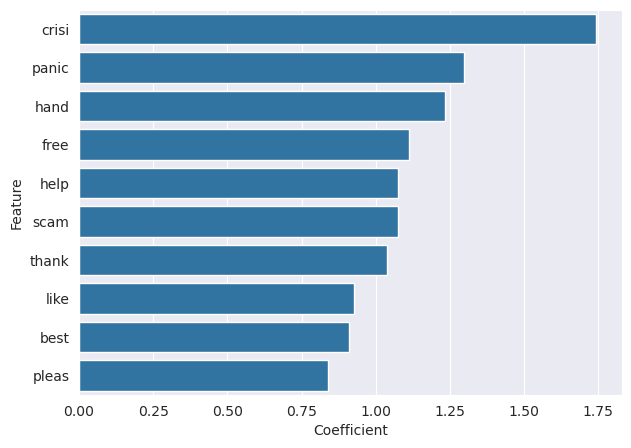

In [127]:
feature_names = cv_df.get_feature_names_out()
coefs = abs(clf.coef_[0])

coefs_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs
})

top = coefs_df.nlargest(10, 'Coefficient')

plt.figure(figsize=(7, 5))
sns.barplot(x='Coefficient', y='Feature', data=top)
plt.title('Top 10 features')
plt.show()

**Ответ:** Они имеют ярковыражанный положительный/отрицательный семантический окрас

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [134]:
from sklearn.feature_selection import mutual_info_classif

X_tmp = np.vstack([
    df['UserName'],
    df['ScreenName']
]).T
mi = mutual_info_classif(X_tmp, df['Sentiment'])
print(f"UserName: {mi[0]}, ScreenName: {mi[1]}")

UserName: 0.003528197777592723, ScreenName: 0.0030558092285413174


**Ответ:** Признаки UserName и ScreenName не полезны для целевой переменной, их добавление не повысит качество модели

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [149]:
df['TweetAt_dt'] = pd.to_datetime(df['TweetAt'], dayfirst=True)

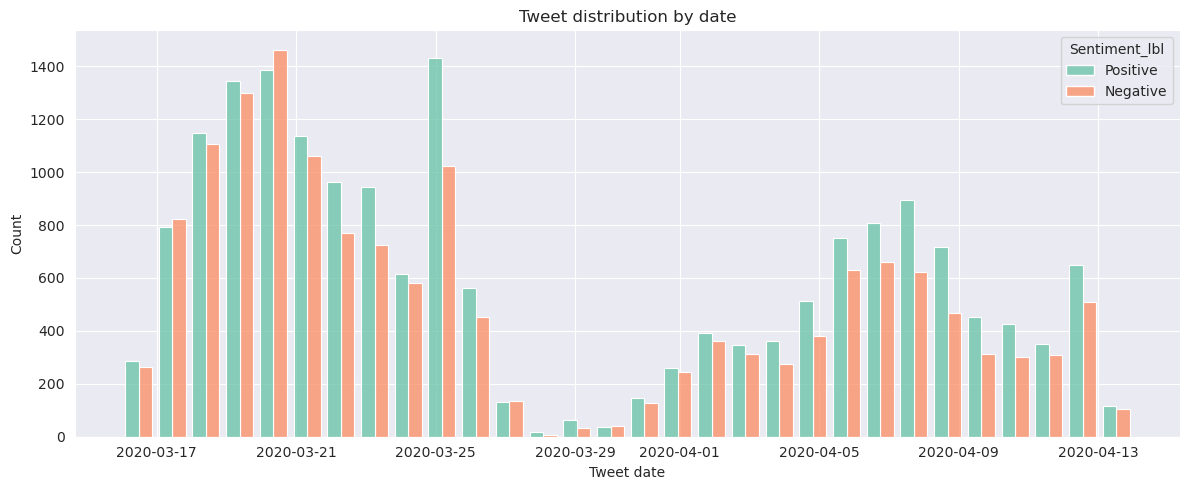

In [148]:
df['Sentiment_lbl'] = df['Sentiment'].map({0: 'Negative', 1: 'Positive'})

plt.figure(figsize=(12, 5))
ax = sns.histplot(
    data=df,
    x='TweetAt_dt',
    hue='Sentiment_lbl',
    element='bars',
    multiple='dodge',
    shrink=0.8,
    bins=30,
    palette='Set2'
)


ax.set_title('Tweet distribution by date')
ax.set_xlabel('Tweet date')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

**Ответ:** Признак TweetAt не полезен для целевой переменной, так как распределение позитивных отзывов совпадает с распределением отрицательных, его добавление не повысит качество модели



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [152]:
df['Location'].nunique()

10465

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

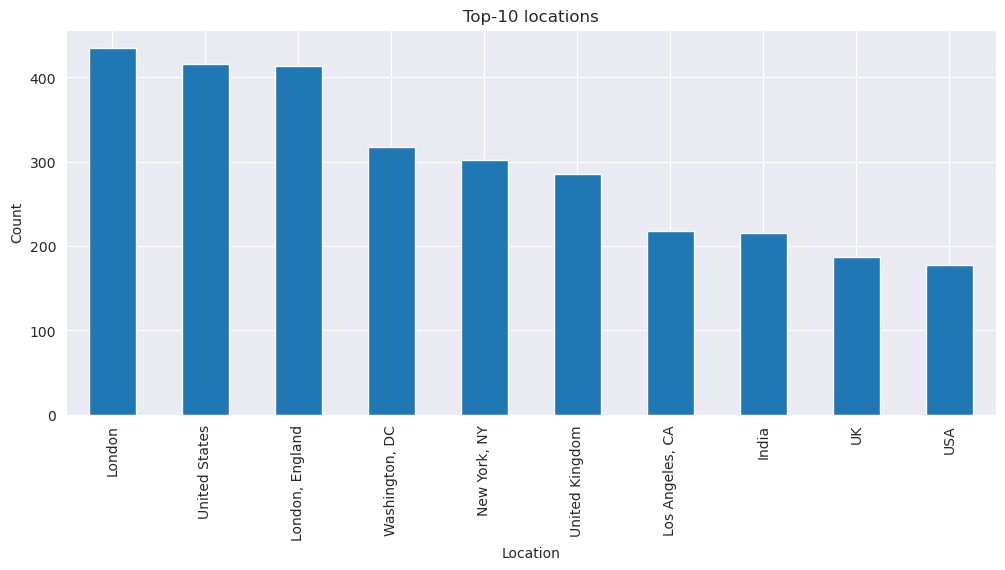

In [156]:
plt.figure(figsize=(12, 5))
df['Location'].value_counts()[1:11].plot(kind='bar')
plt.title('Top-10 locations')
plt.ylabel('Count')
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [167]:
df['WiderLocation'] = df['Location'].apply(lambda x: x.split(',')[-1].strip())
test['WiderLocation'] = test['Location'].apply(lambda x: x.split(',')[-1].strip())
train['WiderLocation'] = train['Location'].apply(lambda x: x.split(',')[-1].strip())
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,TweetAt_dt,Sentiment_lbl,WiderLocation,WiderLocation_masked
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1,2020-03-16,Positive,UK,UK
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1,2020-03-16,Positive,Vagabonds,OTHER
2,3802,48754,Unknown,16-03-2020,My food stock is not the only one which is emp...,1,2020-03-16,Positive,Unknown,Unknown
3,3803,48755,Unknown,16-03-2020,"Me, ready to go at supermarket during the #COV...",0,2020-03-16,Negative,Unknown,Unknown
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,1,2020-03-16,Positive,-82.363649,OTHER


In [163]:
df['WiderLocation'].nunique()

6118

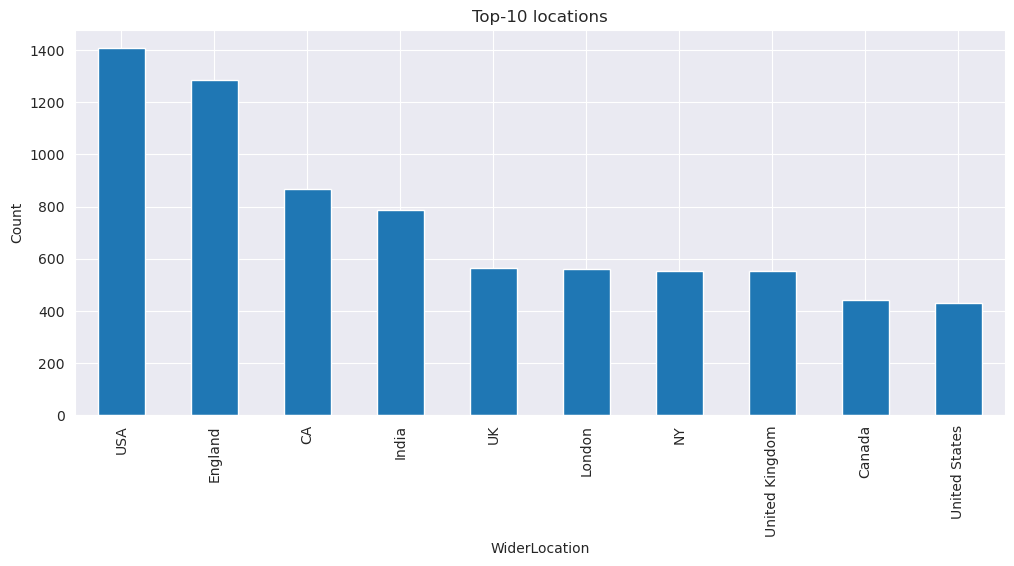

In [164]:
plt.figure(figsize=(12, 5))
df['WiderLocation'].value_counts()[1:11].plot(kind='bar')
plt.title('Top-10 locations')
plt.ylabel('Count')
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [172]:
from sklearn.preprocessing import OneHotEncoder

counts = df['WiderLocation'].value_counts()

eligible = counts[counts > 1].index.tolist()

train['WiderLocation_masked'] = train['WiderLocation'].where(
    train['WiderLocation'].isin(eligible),
    other='OTHER'
)

test['WiderLocation_masked'] = test['WiderLocation'].where(
    test['WiderLocation'].isin(eligible),
    other='OTHER'
)

ohe = OneHotEncoder(
    categories=[eligible],
    sparse_output=True,
    handle_unknown='ignore',
    dtype=int
)

ohe_loc_train = ohe.fit_transform(train['WiderLocation_masked'].values.reshape(-1, 1))
ohe_loc_test = ohe.transform(test['WiderLocation_masked'].values.reshape(-1, 1))

In [173]:
len(eligible)

1308

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [190]:
from scipy.sparse import hstack

X_train_full = hstack([X_train_scaled, ohe_loc_train])
X_test_full = hstack([X_test_scaled, ohe_loc_test])

clf = LogisticRegression(random_state=42)
clf.fit(X_train_full, y_train)

y_pred = clf.predict(X_test_full)
accuracy_score(y_test, y_pred)

/home/andre/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8450269085110624

**Ответ:** Признак улучшил метрику не более чем на одну тысячную, можно сделать, вывод, что пользы от признака нет